In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

# Machine learning models and toolss
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# This is from a different library
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [52]:
# Create a dataframe of the csv file
data = pd.read_csv("final_dataset.csv")
data.head()

,category,product name,location,price,overall rating,number sold,total review,customer review,sentiment,region,salary
0,computers and laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,jakarta utara,53500,4.9,5449,2369,Alhamdulillah berfungsi dengan baik. Packaging...,1,dki jakarta,5396760.0
1,computers and laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,tangerang selatan,72000,4.9,2359,1044,"barang bagus dan respon cepat, harga bersaing ...",1,banten,2905119.0
2,computers and laptops,SSD Midasforce 128 Gb - Tanpa Caddy,jakarta barat,213000,5.0,12300,3573,"barang bagus, berfungsi dengan baik, seler ram...",1,dki jakarta,5396760.0
3,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,bagus sesuai harapan penjual nya juga ramah. t...,1,dki jakarta,5396760.0
4,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",1,dki jakarta,5396760.0


In [53]:
x = data[["price","overall rating","sentiment","total review","salary"]]
# x = data[["total review"]] # This feature alone has the highest correlation with the label
y = data["number sold"]

print("x shape:", x.shape)

x shape: (5147, 5)


In [54]:
# Another data split for the x data with no added polynomial features (this is for the tree based models)
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

In [55]:
LR = LinearRegression()
RFR = RandomForestRegressor()
XGB = XGBRegressor()

TRAINING THE MACHINE LEARNING MODELS

In [56]:
# 1. Linear Regression
LR.fit(x_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [57]:
# 2. Random Forest Regressora
RFR.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [58]:
# 3. XGBoost Regressor
XGB.fit(x_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_met

In [59]:
# PREDICTIONS
pred_lr  = LR.predict(x_test)
pred_rf  = RFR.predict(x_test)
pred_xgb = XGB.predict(x_test)

# EVALUATION
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Evaluation Metrics for {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2 ): {r2}")
    print("\n")

evaluate_model(y_test, pred_lr, "Linear Regression")
evaluate_model(y_test, pred_rf, "Random Forest Regressor")
evaluate_model(y_test, pred_xgb, "XGBoost Regressor")

Evaluation Metrics for Linear Regression:
Mean Absolute Error (MAE): 6734.051148472391
Mean Squared Error (MSE): 231158447.10872537
R-squared (R2 ): 0.1666456434620066


Evaluation Metrics for Random Forest Regressor:
Mean Absolute Error (MAE): 382.87682601851117
Mean Squared Error (MSE): 2525644.654170474
R-squared (R2 ): 0.9908947434024339


Evaluation Metrics for XGBoost Regressor:
Mean Absolute Error (MAE): 498.3097839355469
Mean Squared Error (MSE): 2995919.75
R-squared (R2 ): 0.9891993403434753




C:\Users\Barri\AppData\Local\Temp\ipykernel_7224\1081100208.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


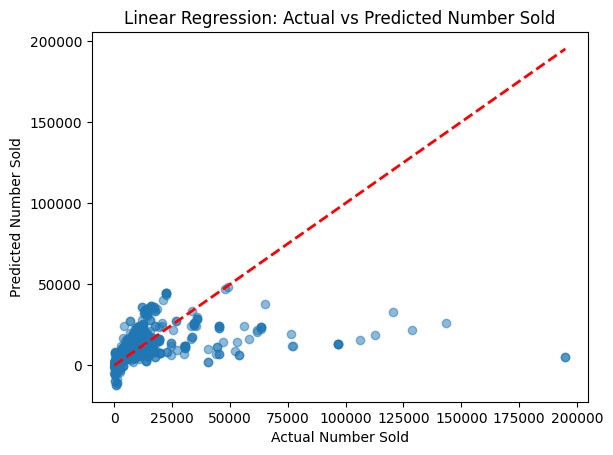

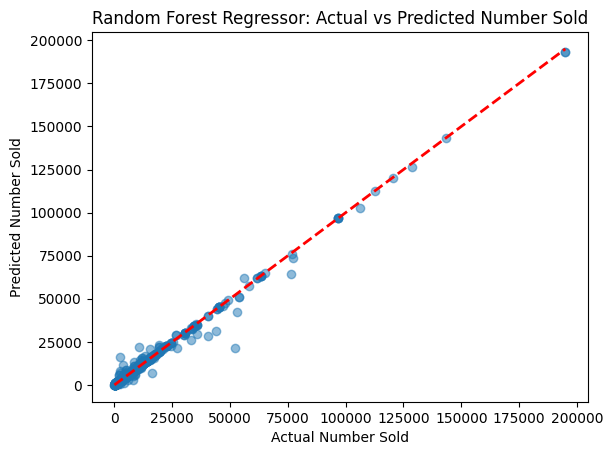

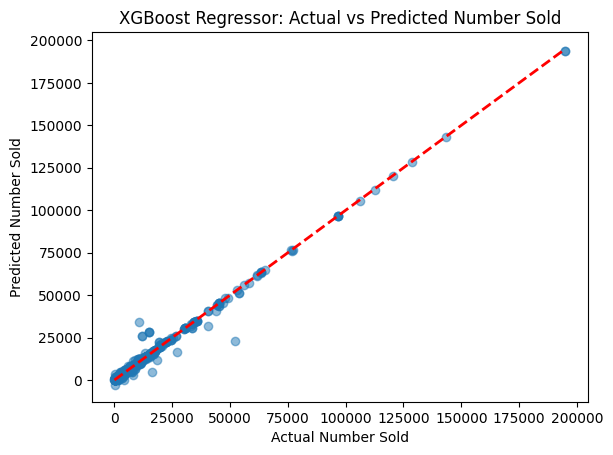

In [60]:
# Actual prediction vs predicted plot for the best model
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Number Sold")
    plt.ylabel("Predicted Number Sold")
    plt.title(f"{model_name}: Actual vs Predicted Number Sold")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
    plt.show()

plot_actual_vs_predicted(y_test, pred_lr, "Linear Regression")
plot_actual_vs_predicted(y_test, pred_rf, "Random Forest Regressor")
plot_actual_vs_predicted(y_test, pred_xgb, "XGBoost Regressor")

Feature Importance

In [61]:
print("\nFeature Importance for Random Forest Regressor:")
for name, importace in zip(x.columns, RFR.feature_importances_):
    print(f"{name}: {importace}")


Feature Importance for Random Forest Regressor:
price: 0.4529769584373435
overall rating: 0.05537888910725753
sentiment: 0.004082960008282336
total review: 0.445671762861598
salary: 0.04188942958551861


In [62]:
from sklearn.inspection import permutation_importance
result_RFR = permutation_importance(LR, x_test, y_test, n_repeats=10, random_state=42)
print("\nPermutation Importance for Linear Regression:")
for name, importance in zip(x.columns, result_RFR.importances_mean):
    print(f"{name}: {importance}")

print("\nFeature Importance for XGBoost Regressor:")
for name, importance in zip(x.columns, XGB.feature_importances_):
    print(f"{name}: {importance}")


Permutation Importance for Linear Regression:
price: 0.023240131760225602
overall rating: 0.00022707824175002277
sentiment: 0.0018628610135920987
total review: 0.3679351276193857
salary: -0.001125128147564569

Feature Importance for XGBoost Regressor:
price: 0.2759649455547333
overall rating: 0.2514270842075348
sentiment: 0.0015688586281612515
total review: 0.30347973108291626
salary: 0.16755937039852142


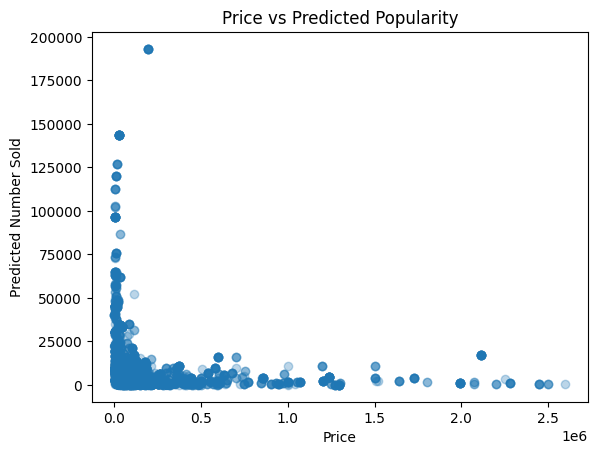

In [63]:
# Finding the optimal price ranges using the dataset, by plotting the prices vs predicted number sold
data["predicted sold"] = RFR.predict(x)
plt.scatter(data["price"], data["predicted sold"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Predicted Number Sold")
plt.title("Price vs Predicted Popularity")
plt.show()

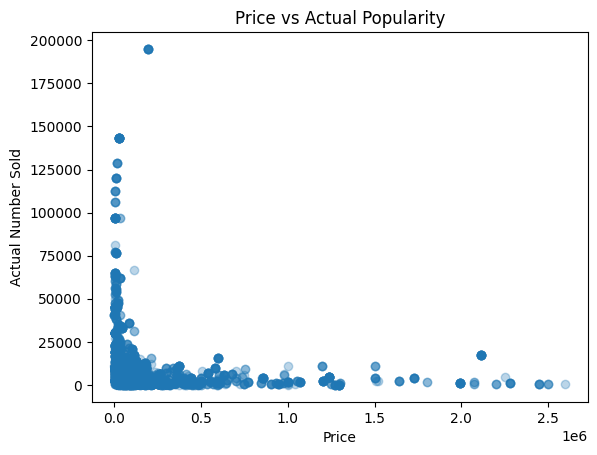

In [64]:
plt.scatter(data["price"], data["number sold"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Actual Number Sold")
plt.title("Price vs Actual Popularity")
plt.show()

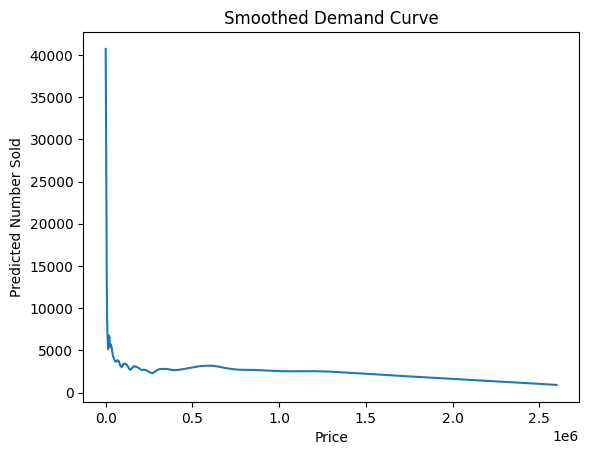

In [65]:
from statsmodels.nonparametric.smoothers_lowess import lowess

data_smooth = data[["price", "predicted sold"]].dropna().sort_values("price")
smooth = lowess(data_smooth["predicted sold"], data_smooth["price"], frac=0.12)

plt.plot(smooth[:,0], smooth[:,1])
plt.xlabel("Price")
plt.ylabel("Predicted Number Sold")
plt.title("Smoothed Demand Curve")
plt.show()


In [66]:
data

,category,product name,location,price,overall rating,number sold,total review,customer review,sentiment,region,salary,predicted sold
0,computers and laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,jakarta utara,53500,4.9,5449,2369,Alhamdulillah berfungsi dengan baik. Packaging...,1,dki jakarta,5396760.0,5446.11
1,computers and laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,tangerang selatan,72000,4.9,2359,1044,"barang bagus dan respon cepat, harga bersaing ...",1,banten,2905119.0,2507.07
2,computers and laptops,SSD Midasforce 128 Gb - Tanpa Caddy,jakarta barat,213000,5.0,12300,3573,"barang bagus, berfungsi dengan baik, seler ram...",1,dki jakarta,5396760.0,10936.67
3,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,bagus sesuai harapan penjual nya juga ramah. t...,1,dki jakarta,5396760.0,2043.35
4,computers and laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,jakarta timur,55000,4.7,2030,672,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",1,dki jakarta,5396760.0,2043.35
...,...,...,...,...,...,...,...,...,...,...,...,...
5142,household,PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...,jakarta pusat,35000,4.9,1431,562,"Harga bersaing, barang sesuai pesanan. Saya na...",1,dki jakarta,5396760.0,1428.17
5143,household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,jakarta utara,99000,4.9,15529,4074,Beli ini krn Anak & Istri mau liburan di Jakar...,1,dki jakarta,5396760.0,15529.00
5144,household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,jakarta utara,99000,4.9,15529,4074,"pengemasan barang baik, kondisi barang jg utuh...",1,dki jakarta,5396760.0,15529.00
5145,household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,jakarta utara,99000,4.9,15529,4074,Mungil tapi bekerja dng baik. Dan murahh terja...,1,dki jakarta,5396760.0,15529.00


In [67]:
# Calculate demand gaps per region
# Group by region and compare predicted vs actual demand
region_analysis = data.groupby("region").agg({
    "predicted sold": "mean",
    "number sold": "mean",
    "price": "mean"
}).reset_index()

region_analysis["demand_gap"] = region_analysis["number sold"] - region_analysis["predicted sold"]
region_analysis["gap_percentage"] = (region_analysis["demand_gap"] / region_analysis["predicted sold"]) * 100

# Sort by demand gap to identify biggest opportunities (negative = underperforming)
region_analysis = region_analysis.sort_values("demand_gap", ascending=False)

print("\nRegional Demand Gap Analysis:")
print(region_analysis.to_string(index=False))


Regional Demand Gap Analysis:
           region  predicted sold  number sold         price  demand_gap  gap_percentage
          lampung    25855.470000 33200.000000  18000.000000 7344.530000       28.406097
       jawa timur     6303.886554  6476.986486 146678.432432  173.099932        2.745924
 sumatera selatan    12115.261389 12191.527778  27680.555556   76.266389        0.629507
      dki jakarta     8217.133259  8239.200190 177962.835547   22.066931        0.268548
kalimantan tengah      418.870000   429.000000  37500.000000   10.130000        2.418411
    di yogyakarta     1937.357500  1939.937500  42481.250000    2.580000        0.133171
             bali     2660.000000  2660.000000  26900.000000    0.000000        0.000000
        kep. riau      436.610000   414.000000  90000.000000  -22.610000       -5.178535
           banten     9544.735885  9517.943081 163926.448479  -26.792804       -0.280708
       jawa barat    11129.300761 11063.221397  67606.355126  -66.079365       

In [68]:
# Find ideal price ranges per location (similar to category analysis)
location_ranges = {}

for loc in data["location"].unique():
    sub = data[data["location"] == loc]
    thr = sub["predicted sold"].quantile(0.90)
    top = sub[sub["predicted sold"] >= thr]
    
    location_ranges[loc] = (top["price"].min(), top["price"].max())

print(location_ranges)

print("Ideal Price Ranges by Location:")
for location, (min_price, max_price) in location_ranges.items():
    print(f"{location}: {int(min_price)} ~ {int(max_price)}")

{'jakarta utara': (np.int64(990), np.int64(195000)), 'tangerang selatan': (np.int64(7500), np.int64(112000)), 'jakarta barat': (np.int64(349), np.int64(110000)), 'jakarta timur': (np.int64(2850), np.int64(79900)), 'jakarta selatan': (np.int64(176), np.int64(85000)), 'jakarta pusat': (np.int64(850), np.int64(2114000)), 'bandung': (np.int64(5400), np.int64(48000)), 'depok': (np.int64(1500), np.int64(65000)), 'surabaya': (np.int64(7999), np.int64(64000)), 'tangerang': (np.int64(2000), np.int64(599000)), 'bekasi': (np.int64(1400), np.int64(19500)), 'malang': (np.int64(42000), np.int64(46000)), 'tegal': (np.int64(6000), np.int64(6000)), 'batang': (np.int64(59800), np.int64(59800)), 'bandar lampung': (np.int64(18000), np.int64(18000)), 'cianjur': (np.int64(16000), np.int64(16000)), 'palembang': (np.int64(30500), np.int64(30500)), 'surakarta': (np.int64(79499), np.int64(79499)), 'bogor': (np.int64(2000), np.int64(2000)), 'sleman': (np.int64(65800), np.int64(65800)), 'sidoarjo': (np.int64(2000

In [69]:
ideal_ranges = {}

for c in data["category"].unique():
    sub = data[data["category"] == c]
    thr = sub["predicted sold"].quantile(0.90)
    top = sub[sub["predicted sold"] >= thr]
    
    ideal_ranges[c] = (top["price"].min(), top["price"].max())

# Display formatted results
for category, (min_price, max_price) in ideal_ranges.items():
    print(f"{category}: {int(min_price)} ~ {int(max_price)}")


computers and laptops: 18000 ~ 699000
toys and hobbies: 4150 ~ 27000
food and drink: 5400 ~ 70000
office & stationery: 3650 ~ 35000
automotive: 1500 ~ 9000
animal care: 19500 ~ 29500
body care: 29100 ~ 29100
party supplies and craft: 349 ~ 110000
carpentry: 3300 ~ 3700
other products: 1400 ~ 10000
sport: 11000 ~ 59999
precious metal: 39100 ~ 39100
property: 8400 ~ 80000
tour and travel: 199000 ~ 749900
books: 4000 ~ 50000
kitchen: 3199 ~ 599000
electronics: 18370 ~ 90000
kids and baby fashion: 9000 ~ 9250
muslim fashion: 3345 ~ 13500
men's fashion: 8900 ~ 1500000
women's fashion: 15000 ~ 30500
movies and music: 29490 ~ 298500
gaming: 850 ~ 359000
phones and tablets: 18000 ~ 2114000
mother and baby: 31478 ~ 52500
camera: 9500 ~ 180000
beauty: 20000 ~ 125000
health: 30000 ~ 84000
household: 825 ~ 115000


In [70]:
# Detailed location-level analysis for the biggest gap regions
print("\n=== DETAILED LOCATION ANALYSIS ===")
top_gap_regions = region_analysis.head(3)["region"].values

for reg in top_gap_regions:
    print(f"\n--- {reg} ---")
    loc_data = data[data["region"] == reg].groupby("location").agg({
        "predicted sold": "mean",
        "number sold": "mean",
        "price": "mean"
    }).reset_index()
    
    loc_data["demand_gap"] = loc_data["number sold"] - loc_data["predicted sold"]
    loc_data = loc_data.sort_values("demand_gap", ascending=False)
    print(loc_data.to_string(index=False))


=== DETAILED LOCATION ANALYSIS ===

--- lampung ---
      location  predicted sold  number sold   price  demand_gap
bandar lampung        25855.47      33200.0 18000.0     7344.53

--- jawa timur ---
   location  predicted sold  number sold         price  demand_gap
   surabaya     5865.342234  6151.510638 129853.276596  286.168404
tulungagung      326.000000   326.000000 299900.000000    0.000000
   sidoarjo    14892.527143 14885.857143 123142.857143   -6.670000
     kediri     8994.025625  8984.375000  23512.500000   -9.650625
     malang     1472.086364  1406.545455 382545.454545  -65.540909
  mojokerto     3260.100000  3156.000000  65000.000000 -104.100000

--- sumatera selatan ---
 location  predicted sold  number sold        price  demand_gap
palembang    12115.261389 12191.527778 27680.555556   76.266389


In [71]:
region_analysis

,region,predicted sold,number sold,price,demand_gap,gap_percentage
9,lampung,25855.470000,33200.000000,18000.000000,7344.530000,28.406097
6,jawa timur,6303.886554,6476.986486,146678.432432,173.099932,2.745924
11,sumatera selatan,12115.261389,12191.527778,27680.555556,76.266389,0.629507
3,dki jakarta,8217.133259,8239.200190,177962.835547,22.066931,0.268548
7,kalimantan tengah,418.870000,429.000000,37500.000000,10.130000,2.418411
2,di yogyakarta,1937.357500,1939.937500,42481.250000,2.580000,0.133171
0,bali,2660.000000,2660.000000,26900.000000,0.000000,0.000000
8,kep. riau,436.610000,414.000000,90000.000000,-22.610000,-5.178535
1,banten,9544.735885,9517.943081,163926.448479,-26.792804,-0.280708
4,jawa barat,11129.300761,11063.221397,67606.355126,-66.079365,-0.593742


In [72]:
# Identify specific regions with supply gaps or pricing mismatches
print("\n=== REGIONS OVERPERFORMING (Actual > Predicted) ===")
overperforming = region_analysis[region_analysis["demand_gap"] > 0]
print(overperforming[["region", "demand_gap", "gap_percentage", "price"]].to_string(index=False))

print("\n=== REGIONS UNDERPERFORMING (Actual < Predicted) ===")
underperforming = region_analysis[region_analysis["demand_gap"] < 0]
print(underperforming[["region", "demand_gap", "gap_percentage", "price"]].to_string(index=False))


=== REGIONS OVERPERFORMING (Actual > Predicted) ===
           region  demand_gap  gap_percentage         price
          lampung 7344.530000       28.406097  18000.000000
       jawa timur  173.099932        2.745924 146678.432432
 sumatera selatan   76.266389        0.629507  27680.555556
      dki jakarta   22.066931        0.268548 177962.835547
kalimantan tengah   10.130000        2.418411  37500.000000
    di yogyakarta    2.580000        0.133171  42481.250000

=== REGIONS UNDERPERFORMING (Actual < Predicted) ===
          region  demand_gap  gap_percentage         price
       kep. riau  -22.610000       -5.178535  90000.000000
          banten  -26.792804       -0.280708 163926.448479
      jawa barat  -66.079365       -0.593742  67606.355126
  sumatera utara  -80.330000       -1.888638  29000.000000
     jawa tengah -255.238358       -5.717495  47327.597015
sulawesi selatan -438.640000      -15.894827  50000.000000


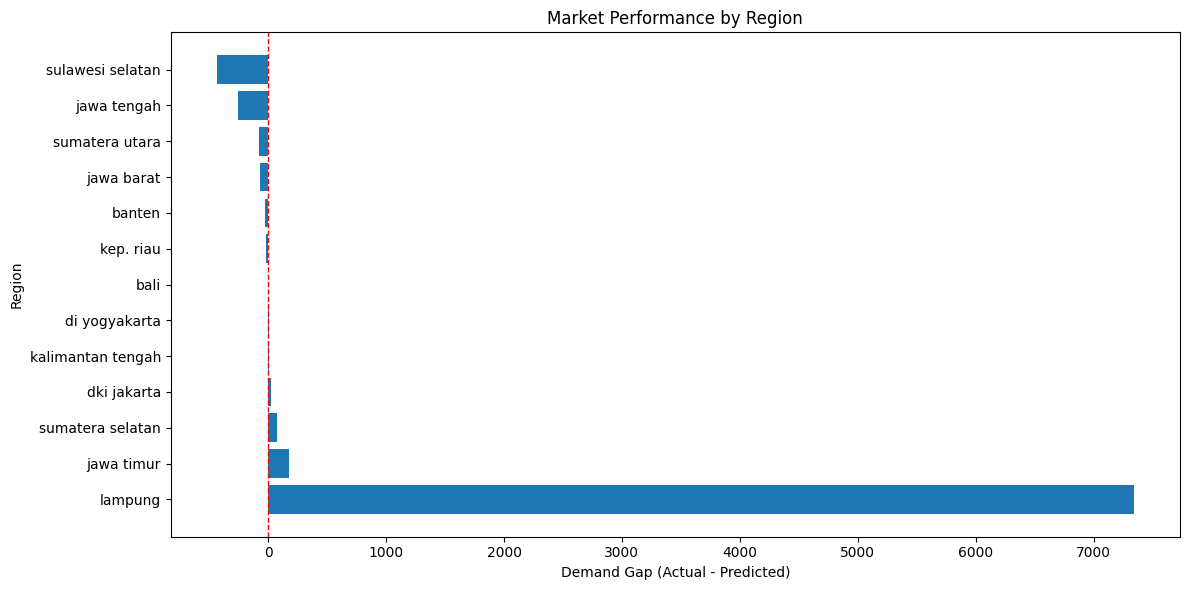

In [73]:
# Visualize demand gaps by region
plt.figure(figsize=(12, 6))
plt.barh(region_analysis["region"], region_analysis["demand_gap"])
plt.xlabel("Demand Gap (Actual - Predicted)")
plt.ylabel("Region")
plt.title("Market Performance by Region")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# Positive gap = Overperforming (actual sales > predicted)
# Negative gap = Underperforming (actual sales < predicted)

TUNING OUR BEST PERFORMING MACHINE LEARNING MODEL: STILL ON PROGRESS!

Although we already tuned this to the best settings, it is still not a good model accuracy, therefore we could see that we are still lacking with the features. Now it's time to add more features such as categorical features or even the 'customer review' (the comment from the customer in text form of that particular product). 

We proceed with vectorizing the text file to become numerical. Let's use OneHotEncoder for our categorical features, and using TF-IDF vectorizer for the customer review text (Interesting Note: Since tokopedia comments are in the Indonesian language we use the libarary Sastrawi in order to get the indonesian stop words to then be used by TF-IDF)! 

In [ ]:
# Use this libary for combing the numerical features with the categorical features
from sklearn.compose import ColumnTransformer

# This one is for the categorical features = [category, region]
from sklearn.preprocessing import OneHotEncoder

# This one is for the purely text feature (all suppose to be unique text data) = customer review
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# Get the indonesian stop words
stop_words_ind = StopWordRemoverFactory().get_stop_words()

from sklearn.pipeline import Pipeline

In [ ]:
numerical_features = ["price", "overall rating", "number sold", "total review", "salary"]
categorical_features = ["category", "region"] 
text_features = "customer review"

In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Prediction distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

In [ ]:
unique, counts = np.unique(Y_test, return_counts=True)
print("True label distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")